<a href="https://colab.research.google.com/github/Happychick/Behavioural-data-jazz/blob/master/Podia_LTV_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import statsmodels.api as sm

In [ ]:
pip install snowflake-connector-python[pandas]

# Yearly subscriptions, getting people to make a sale on day 6 and email newsletters are the best indicators of high value customers

### Get Customers onto yearly subscriptions
- Customers on yearly plans retain longer, shown by the share of returning paying users being higher for *straight(yearly plans)* lines than *jagged* ones(monthly)

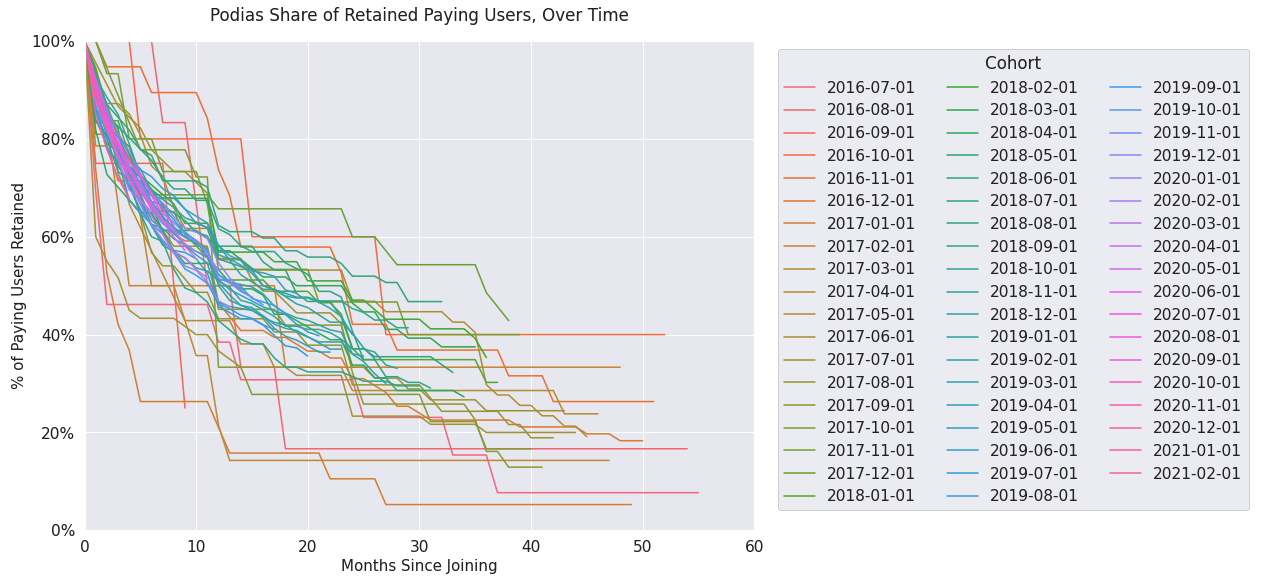

**Recommendations:**
- Default new users into yearly plan

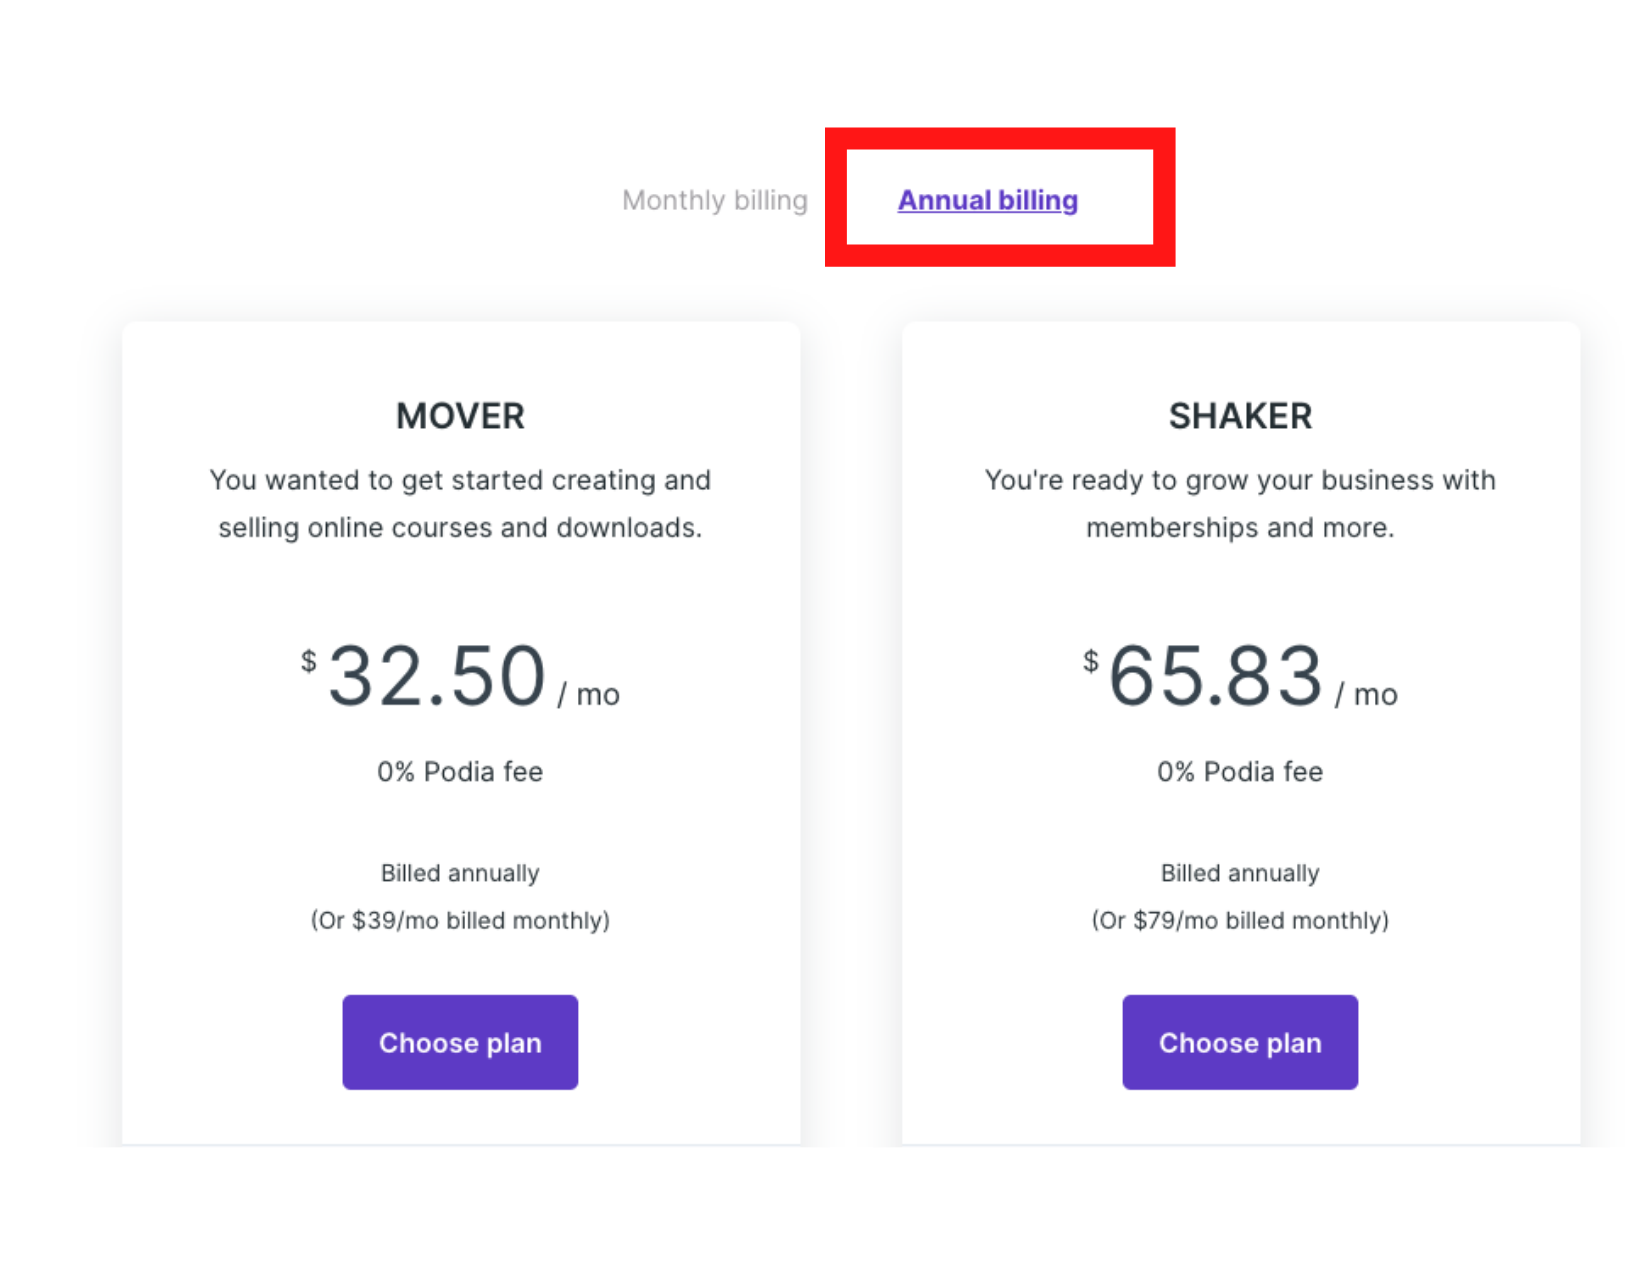

### Help customers make newsletters, and get a sale by day 6 
- Getting people to make a sale on day 6, and sending more email newsletters increases the likelihood that individuals are active for at least 5 months
- Total revenue is not a driving factor of retention

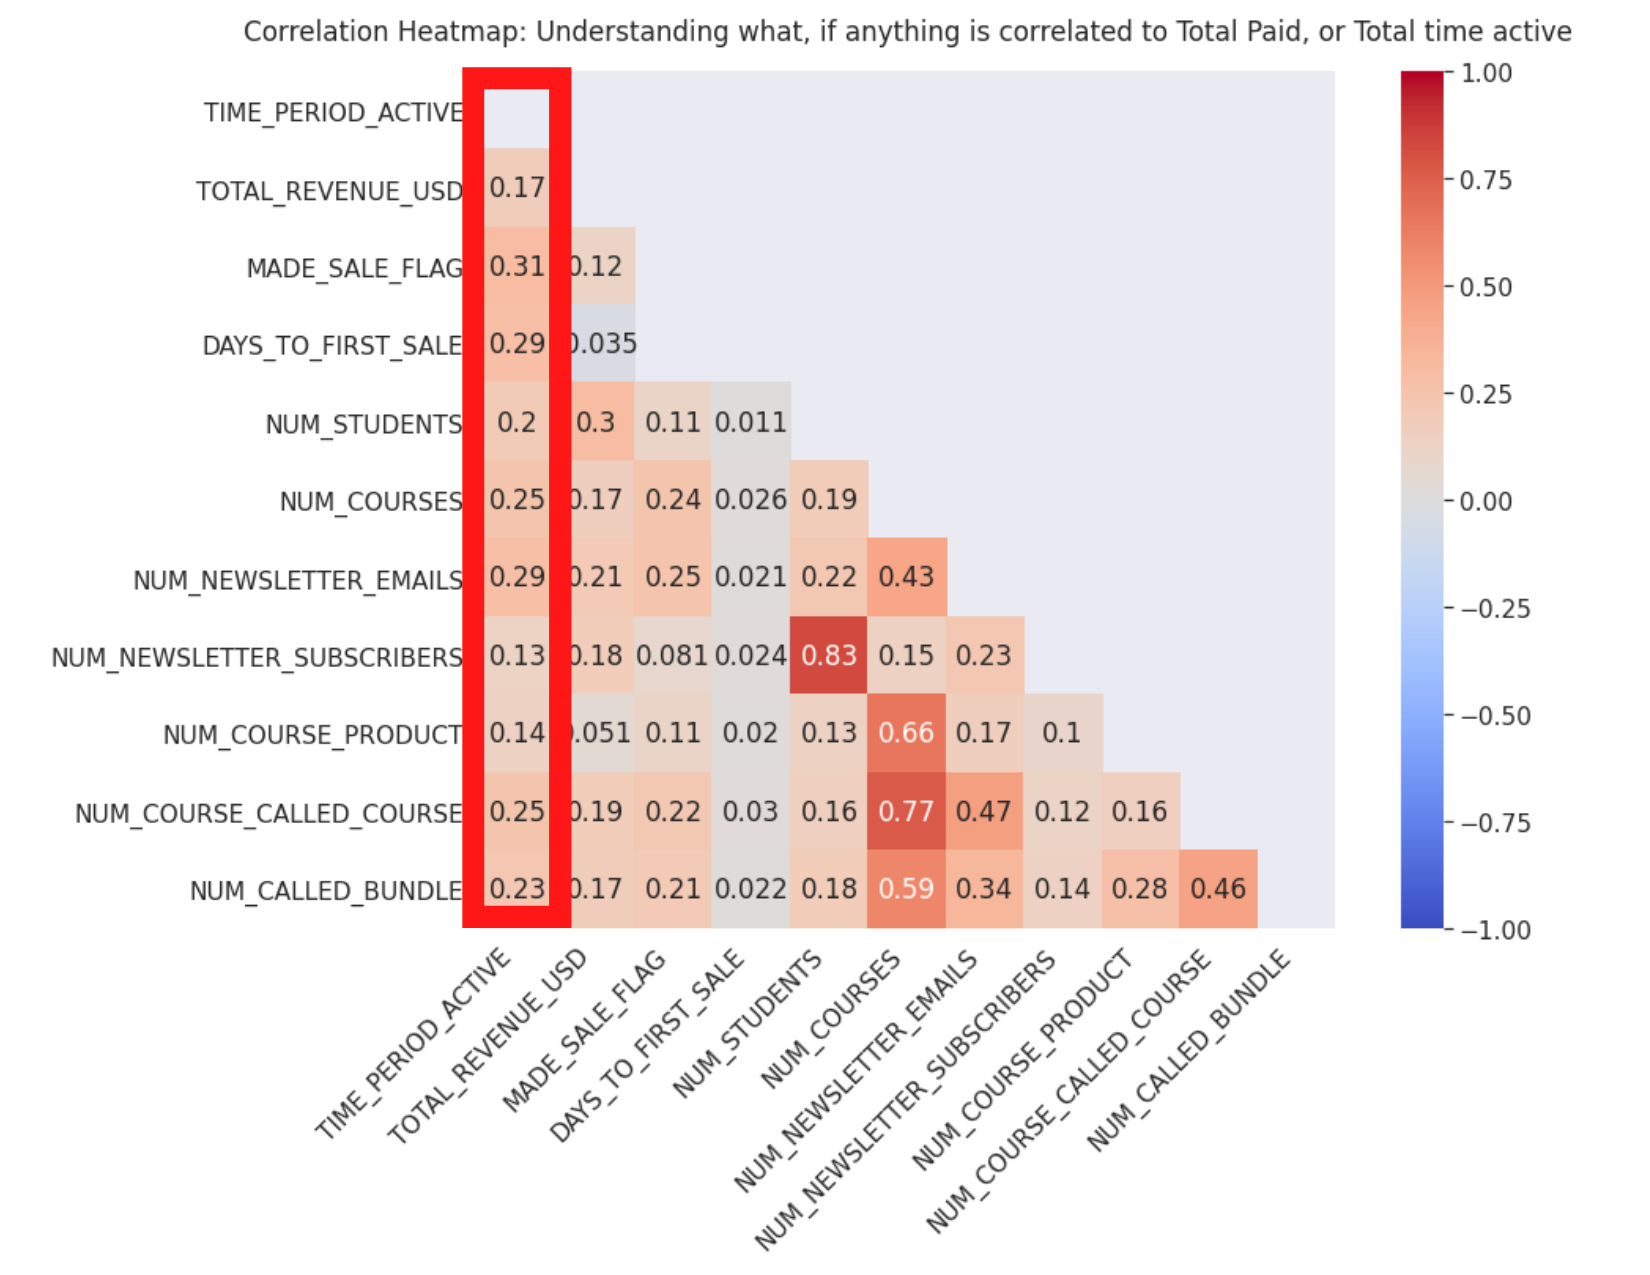

**Recommendations:**
- Change business model to take a % comission of course creators revenue
- Conduct in-depth reserch with creators that made a profit using the platfrom but left anyway to understand driving factors behind leaving platform.
- Send monthly 'Thinking of your next event' promoting newsletter services on Podia website
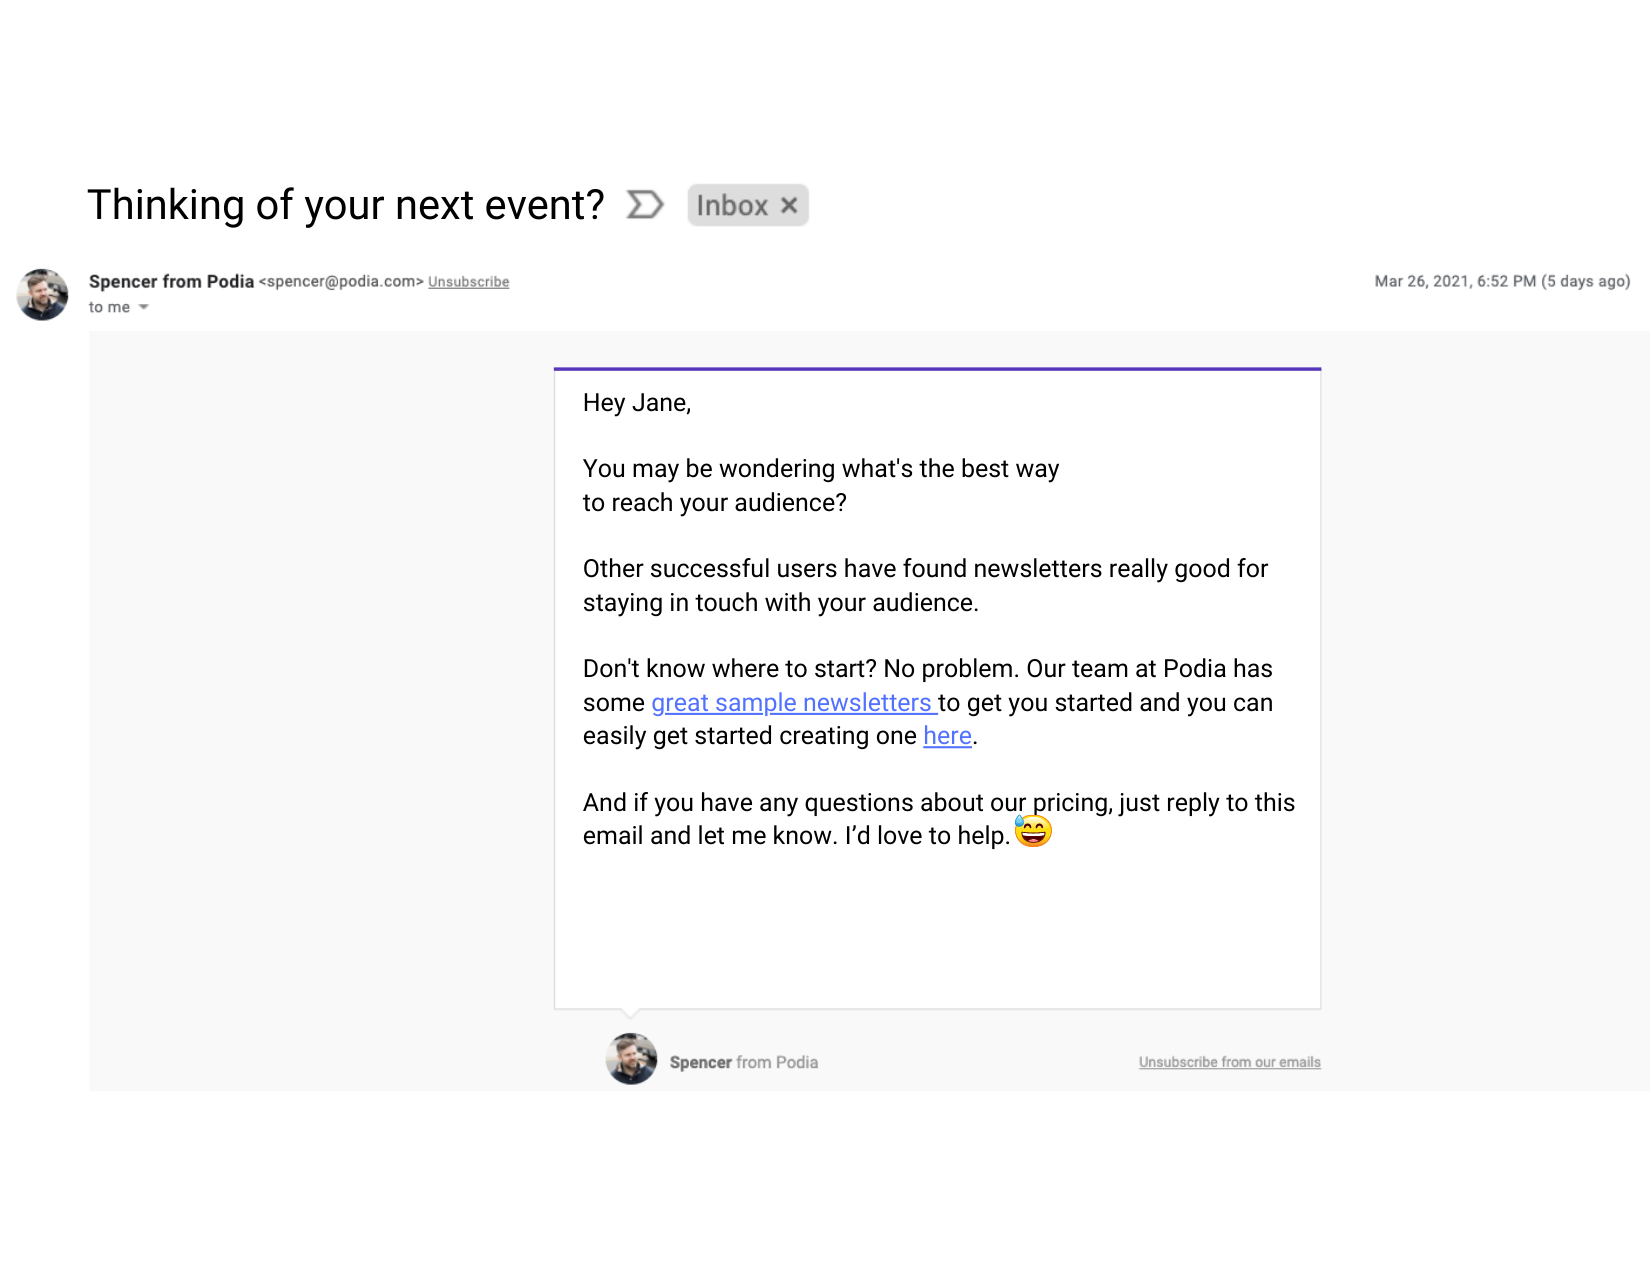

### Improve classification to influence content strategy
Currently, there are **254,137** course categories in the database, with that breadth its impossible to understand the relationship between course type and retention, and therefore make any content strategy recommendations

**Recommendations:**
- Conduct clustering analysis on existing categories to find a reduced set of course categories (DC could do this)
- Create manual classification for courses internally.

# ANALYSES

# Understanding Podia customers that will stick


What is our “magic metric” that can serve as a leading indicator that a customer is likely to continue to success (i.e.fall into a higher LTV band) over time?

In [227]:
# To calculate LTV we want to calculate the max revenue generated by a teacher/site id
# We also want to look at characteristics of people that haven't left the site for a set period of time (e.g.  a year)
# In total there are 15,975 customers

# Read data
# Original data without cut-off date
#jc = pd.read_csv("J-curves.csv") 
jc2 = pd.read_csv("adjusted_dates.csv")
# Get summary stats
#jc.describe()
jc2.describe()

,SITE_ID,TIME_PERIOD_ACTIVE
count,15975.000000,15975.000000
mean,49800.372520,7.733208
std,26369.024828,7.897605
min,1.000000,0.000000
25%,27096.500000,2.000000
50%,47904.000000,5.000000
75%,72166.500000,10.000000
max,99038.000000,56.000000


- 50% of customers pay for 5 months
- Median below mean implies positive skew, aka, the majority of people are below the mean, stay for a shorter time


In [ ]:
jc2.groupby('SITE_STATUS')['SITE_ID'].nunique()

SITE_STATUS
active     8829
churned    7146
Name: SITE_ID, dtype: int64

- But, **55%** of all paying customers **are active as of March 2021**

In this analysis, we will do 2 things:

1.  Understanding the retention of paying users by cohort: J-curve Analysis and
2.  Identify the characteristics of high LTV customers, aka, those that have spent the most time on the platform and have never churned


## 1. Understanding the retention of paying users by cohort: J-curve Analysis

# Recommendations

- The objective of the j-curve is to *find product market fit*. Shown when retention, aka the share of returning monthly users starts **flattening,** month over month. 
- There are some early cohorts that show product market fit, effectively retaining around 40% of customers. However, these cohort sizes are tiny compared to later cohorts 
- We see *smooth*, and *jagged lines*, these reflect purchases of monthly and yearly subscriptions respectively. Yearly subscriptions retain better, as can be seen from the blue lines that reflect monthly drop off at a constant and steeper rate than yearly. 

**Possible Solution**

A clear indication here would be to default users to the yearly price on the website, instead of the monthly one as done at present: 

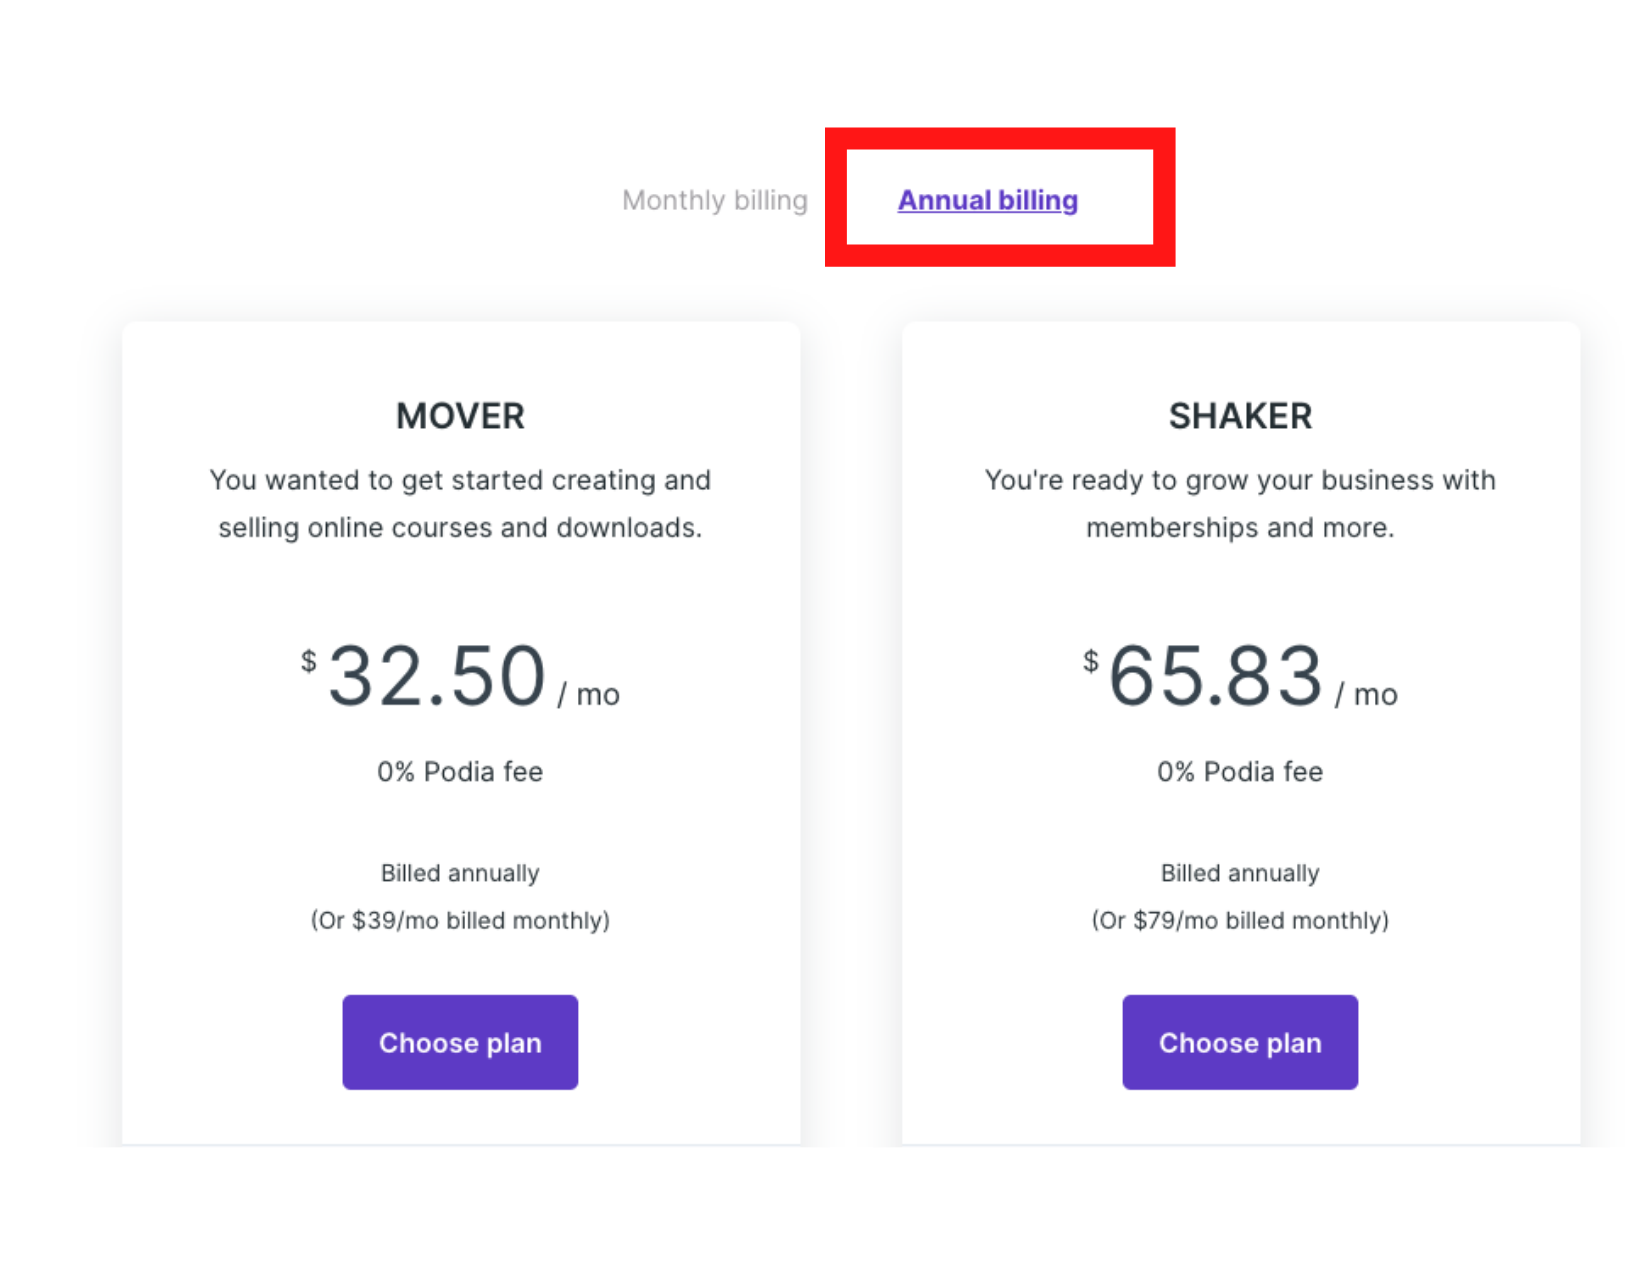

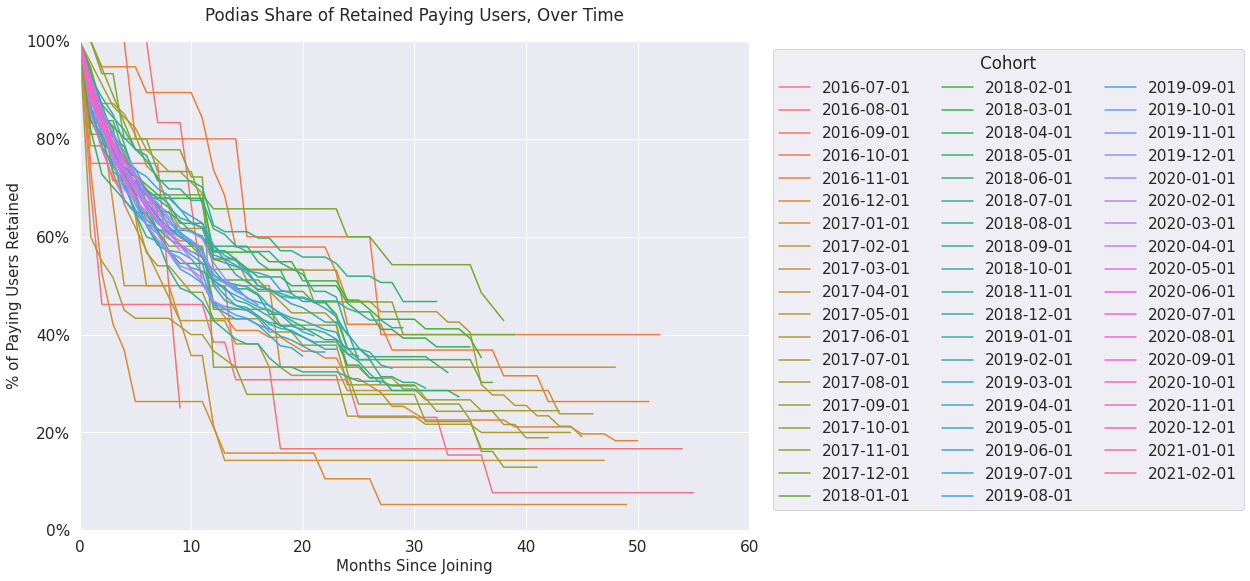

In [ ]:
# Finally, let's plot some j-curves!
# Line plots showing how share of paying users chnges over time, by cohort 

sns.set(font_scale=1.4)

a4_dims = (12, 9)

fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.lineplot(data=agg, x="months_since_started", y="share_paid_retained", hue="COHORT")
ax.set_xlabel(xlabel='Months Since Joining',fontsize=15)
ax.set_ylabel(ylabel='% of Paying Users Retained',fontsize=15)

# control x and y limits
plt.ylim(0, 100)
plt.xlim(0, 60)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

ax.set_title('Podias Share of Retained Paying Users, Over Time', pad =20)

# Move legend
leg = plt.legend(loc = 'upper right',ncol=3,bbox_to_anchor=(1.25, 0.5, 0.5, 0.5),title="Cohort",)

plt.show()

# Technically, this is not quite correct because this includes people 
# With paid subscriptions into the future. So, what I should do is only look at data
# Up to now, as those users haven't churned

In [ ]:
# Create variable months_since_start that's a list for every site id
master_list = []
for site in jc2.SITE_ID.index:
  months_since_start = [i for i in range(jc2.TIME_PERIOD_ACTIVE[site])]
  master_list.append(months_since_start)

jc2['months_since_started'] = master_list

# Now we need to multiply the number of rows by the length of the array
jc2 = jc2.explode('months_since_started').reset_index(drop=True)

jc2.head(56)
# Woop Woop, we have the data in the right format. 
# Now I need to create an aggregated table 


In [ ]:
# Create aggregate table that counts the number of sites by cohort,by month
agg = jc2.groupby(['COHORT','months_since_started'], as_index=False)['SITE_ID'].nunique().rename(columns={'SITE_ID':'sites_per_month'}).sort_values(by='months_since_started')
# Create aggregate table that counts total number of sites per cohort
total = jc2.groupby('COHORT')['SITE_ID'].nunique().reset_index(name='t')
total.index = total['COHORT']
# Add aggregted column to table
agg['total_cohort'] = agg['COHORT'].map(total['t'])
# Make sure that agg table is sorted by cohort and months_since_started
agg = agg.sort_values(by=['COHORT','months_since_started'])
#  Add a final column for % paying users retained
agg['share_paid_retained'] = (agg['sites_per_month']/agg['total_cohort'])*100


# *Analysis without date adjusted*

In [ ]:
# Create variable months_since_start that's a list for every site id
master_list = []
for site in jc.SITE_ID.index:
  months_since_start = [i for i in range(jc.TIME_PERIOD_ACTIVE[site])]
  master_list.append(months_since_start)

jc['months_since_started'] = master_list

# Now we need to multiply the number of rows by the length of the array
jc = jc.explode('months_since_started').reset_index(drop=True)

jc.head(56)
# Woop Woop, we have the data in the right format. 
# Now I need to create an aggregated table 


In [229]:
# Create aggregate table that counts the number of sites by cohort,by month
agg = jc.groupby(['COHORT','months_since_started'], as_index=False)['SITE_ID'].nunique().rename(columns={'SITE_ID':'sites_per_month'}).sort_values(by='months_since_started')
# Create aggregate table that counts total number of sites per cohort
total = jc.groupby('COHORT')['SITE_ID'].nunique().reset_index(name='t')
total.index = total['COHORT']
# Add aggregted column to table
agg['total_cohort'] = agg['COHORT'].map(total['t'])
# Make sure that agg table is sorted by cohort and months_since_started
agg = agg.sort_values(by=['COHORT','months_since_started'])
#  Add a final column for % paying users retained
agg['share_paid_retained'] = (agg['sites_per_month']/agg['total_cohort'])*100


In [ ]:
agg

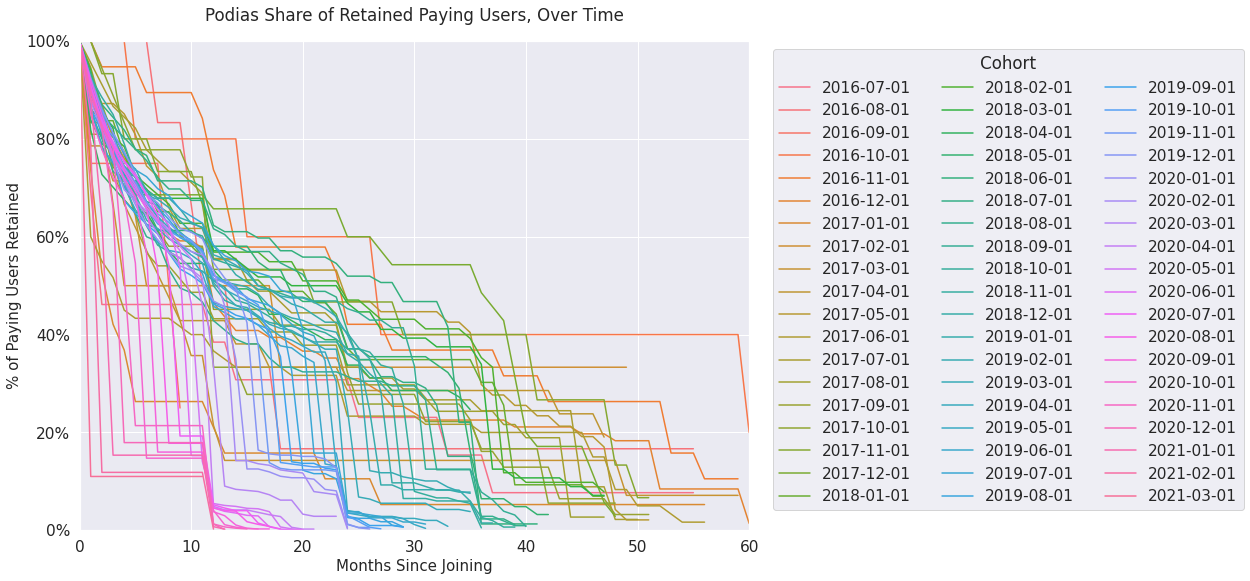

In [230]:
# Finally, let's plot some j-curves!
# Line plots showing how share of paying users chnges over time, by cohort 

sns.set(font_scale=1.4)

a4_dims = (12, 9)

fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.lineplot(data=agg, x="months_since_started", y="share_paid_retained", hue="COHORT")
ax.set_xlabel(xlabel='Months Since Joining',fontsize=15)
ax.set_ylabel(ylabel='% of Paying Users Retained',fontsize=15)

# control x and y limits
plt.ylim(0, 100)
plt.xlim(0, 60)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

ax.set_title('Podias Share of Retained Paying Users, Over Time', pad =20)

# Move legend
leg = plt.legend(loc = 'upper right',ncol=3,bbox_to_anchor=(1.25, 0.5, 0.5, 0.5),title="Cohort",)

plt.show()

# Technically, this is not quite correct because this includes people 
# With paid subscriptions into the future. So, what I should do is only look at data
# Up to now, as those users haven't churned

# 2. Identify the characteristics of high LTV customers, aka, those that have spent the most time on the platform and have never churned



# Recommendations
- With the avilable data, our model has poor predictive power with respect to retention (aka, predicting high LTV). Based on these results we recommend:

# 1. Business Model
- The existence of no relationship between creator revenue and time period active, or amount paid in subscription fees implies that incentives are not aligned. If a user is not staying on the platform when they make money, it feels like the platform is not providing them with value. 

**Possible Solutions:**
1.   Change business model to take a % comission of course creators revenue, this would directly align the incentives of Podia with those of the creators.
2.   Conduct in-depth reserch with creators that made a profit using the platfrom but left anyway to understand driving factors behind leaving platform.



# 2. Magic Metric
- Sending more email newsletters increases the likelihood that a customer stays active!

**Possible Solutions:**
- Incentivizing creators to make newsletters by sending them emails; e.g. we saw you had an event, or that you set up your site, why not tell your audience? could help. 
- Could send monthly write newsletter reminders


# 3. Course Categories
- Currently, there are **254,137** course categories in the database, with that breadth its impossible to understand the relationship between course type and retention. 

**Possible Solutions:**
1.   Conduct clustering analysis on existing categories to find a reduced set,of perhaps 20 of course categories, re-run analysis above and see if a) Course type predicts retention and then b) use that knowledge to acquire/retain creators of a certain category. (DC could do this)
2.   Create manual classification for courses internally. Create limited set of e.g. 20 course categories. Make course tagging a required choice(e.g. in the form of a drop-down) in course setup. 


In [231]:
# Show PDF of when creators joined the site
cdf = jc2.groupby('COHORT')['SITE_ID'].nunique().reset_index(name='t')
total = cdf.t.sum()
# The share for each category represents

cumulative = 0

c = []
p = []

for i,j in cdf.t.items():
    cumulative = cumulative + j
    share = cumulative/total
    c.append(cumulative)
    p.append(share)
    
cdf['cumulative'] = c
cdf['share'] = p

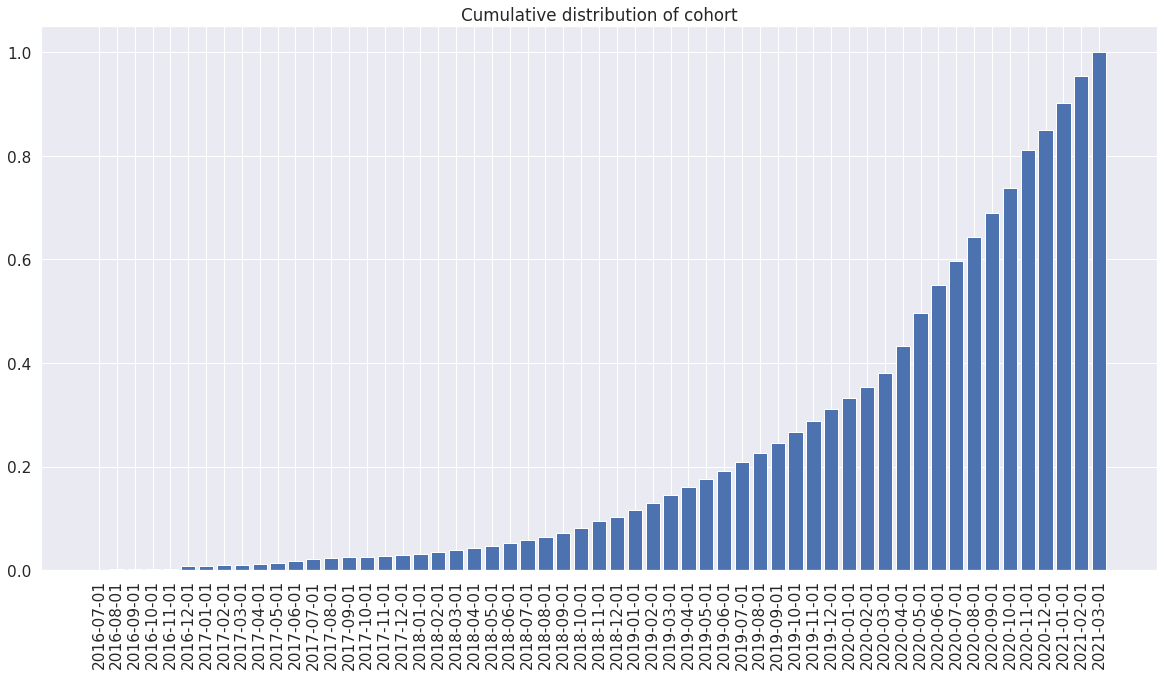

In [232]:
fig = plt.figure(figsize=(20,10))
plt.bar(cdf['COHORT'],cdf['share'])
plt.title("Cumulative distribution of cohort")
plt.xticks(rotation=90)
plt.show()

- Over 60% of creators joined Podia post 2020. 
- It also feels like there was a jump in creators between March and April 2020, coinciding with COVID
- For the purposes of this analysis. We will segment users as prior to 2020 (~30%) and after 2020, as the difference in acquisition numbers could reflect differences in the types of users. (early adopters vs. marketing efforts etc)



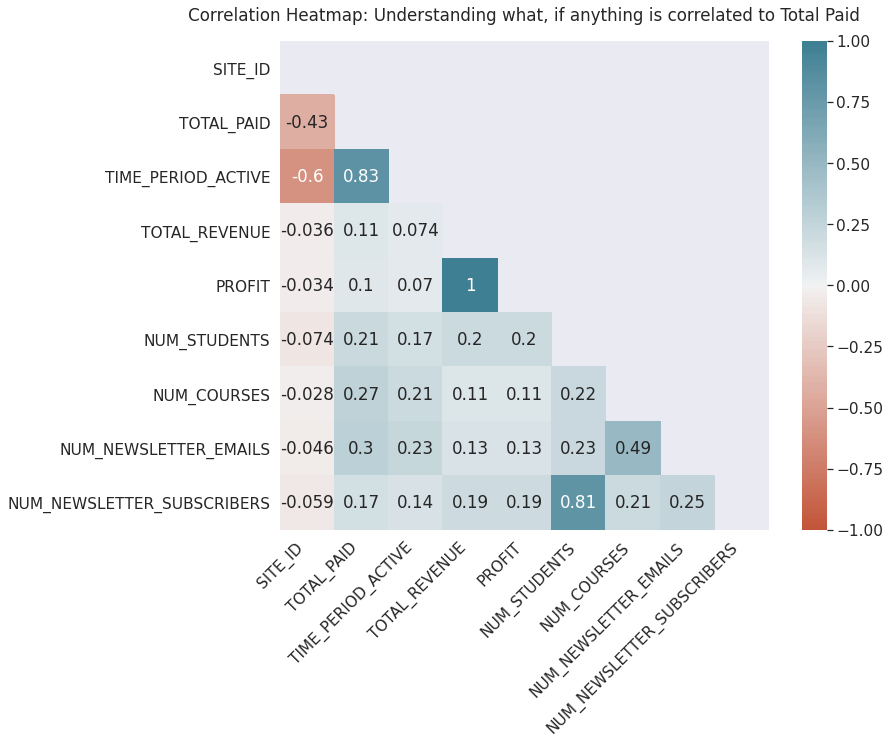

In [249]:
# From the data we have, it looks like barely anything that we have selected is
# Correlate to paying subscriptions

ltv = pd.read_csv('ltv_data.csv')

sns.set(font_scale=1.4)
a4_dims = (12, 9)
fig, ax = plt.subplots(figsize=a4_dims)

corr = ltv.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


ax.set_title("Correlation Heatmap: Understanding what, if anything is correlated to Total Paid", pad =20)

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    mask = mask,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



The data is fairly crap. 

1.   The strong correlation between Total Paid and time period active is clear because you pay more the longer you are on Podia
2.   The fact that both revenue and profit are so loosely correlated with profit is disturbing, implying that users may just have their subscriptions on rather than using the site
3. The only reasonable variables are the indication that num_students, num_courses and num_newsletters are positively correlated, implying that if creators can build a following on podia, that is correlated to them staying longer. 

In terms of "magic metric", it feels like num courses or newsletter emails are good variables to explore

Overall, I don't trust this data. I am not sure of its validaity and it feels like the predictive power is poor. Would recommend validating data sources




# Building a model to "predict" active



In [189]:
# I am not hopeful of the strength of this due to data issues above, 
# but perhaps we can just re-run this once we have the clean data

# Import Pacakages
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


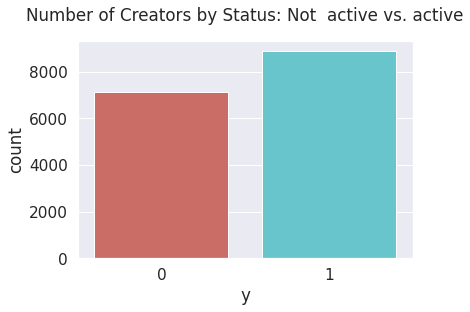

In [253]:
# Create y variable
# For logisitc regression, 1 is active, and 0 is churned
ltv.head()

ltv['y'] = [1 if status=="active" else 0 for status in ltv['SITE_STATUS']]
# For regression, need to drop variables correlated to one another so

# 1. No profit (keep Total Revenue instead)
# 2. Should probably drop time_active too, although since we are not looking at amount paid, might be less bad

ltv['y'].value_counts
sns.countplot(x='y',data=ltv,palette='hls')

plt.title("Number of Creators by Status: Not  active vs. active", pad=20)

plt.show()
# This reflects exactly the data we saw at the top. Given what we saw in the jcurve,
# Im assuming these are newer creators

In [191]:
count_churn = len(ltv[ltv['y']==0])
count_active = len(ltv[ltv['y']==1])
pct_churn= count_churn/(count_churn+count_active)
print("percentage of churn is", pct_churn*100)
pct_active = count_active/(count_churn+count_active)
print("percentage of active", pct_active*100)

percentage of churn is 50.04398132485283
percentage of active 49.95601867514717


In [192]:
ltv.head()

,SITE_ID,COHORT,SITE_STATUS,TOTAL_PAID,YEAR_JOINED,LAST_SEEN,TIME_PERIOD_ACTIVE,TOTAL_REVENUE_USD,PROFIT,MADE_SALE_FLAG,PASSED_1K_FLAG,DAYS_TO_FIRST_SALE,DAYS_TO_PASS_1000,TRIAL_ATTRIBUTION,SUBSCRIPTION_ATTRIBUTION,SUBSCRIPTION_ATTRIBUTION_SUMMARY,NUM_STUDENTS,NUM_COURSES,NUM_NEWSLETTER_EMAILS,NUM_NEWSLETTER_SUBSCRIBERS,LANGUAGE,TIMEZONE,AVG_COURSE_PRICE,NUM_COURSE_PUBLISHED,NUM_COURSE_DRAFT,NUM_COURSE_WEBINAR,NUM_COURSE_PRODUCT,NUM_COURSE_CALLED_COURSE,NUM_CALLED_BUNDLE,y
0,14261,2019-01-01,active,2370.00,pre_2020,2021-03-01,26,2.366071e+06,2.363701e+06,1,1,54.0,54.0,Unknown,Unknown,Unknown,9352,110,179,6409,en,America/New_York,147.756273,89,21,1,51,58,0,1
1,6288,2017-06-01,active,3225.78,pre_2020,2021-03-01,45,2.156540e+06,2.153314e+06,1,1,22.0,22.0,Unknown,Unknown,Unknown,37099,152,121,5795,fr,Europe/Paris,6956.953947,125,27,1,16,119,16,1
2,30048,2019-11-01,active,1343.00,pre_2020,2021-03-01,16,2.068142e+06,2.066799e+06,1,1,25.0,25.0,Unknown,Unknown,Unknown,11735,5,8,0,en,America/New_York,224.000000,5,0,0,0,3,2,1
3,26795,2019-10-01,active,1475.65,pre_2020,2021-03-01,17,1.706888e+06,1.705413e+06,1,1,51.0,51.0,Unknown,Unknown,Unknown,22782,137,339,7094,en,America/New_York,32.062190,72,65,55,1,81,0,1
4,21244,2019-05-01,active,1817.61,pre_2020,2021-03-01,22,1.535069e+06,1.533252e+06,1,1,4.0,4.0,Unknown,Unknown,Unknown,20211,127,486,4882,en,America/New_York,178.393701,93,34,4,12,91,20,1


In [262]:
# Need to convert all categorical variables into numerical dummies
cat_vars=['YEAR_JOINED']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(ltv[var], prefix=var)
    data2=ltv.join(cat_list)
    data=data2

data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [266]:
# Filter out the variables we don't want
# Aka, get rid of the dummy variable that was not a 0 and 1
#data_final=data[to_keep]
# Drop columns based on criteria in intro
# Site_id, too much variability
# data_final = data_final.drop(columns=['SITE_ID', 'PROFIT'])
# data_final = data_final.drop(columns=['LAST_SEEN'])
# data_final = data_final.drop(columns=['COHORT'])
data_final = data_final.drop(columns=['SITE_STATUS'])
data_final.columns.values

array(['TOTAL_PAID', 'TIME_PERIOD_ACTIVE', 'TOTAL_REVENUE',
       'NUM_STUDENTS', 'NUM_COURSES', 'NUM_NEWSLETTER_EMAILS',
       'NUM_NEWSLETTER_SUBSCRIBERS', 'y', 'YEAR_JOINED_post_2020',
       'YEAR_JOINED_pre_2020'], dtype=object)

In [272]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

columns = X_train.columns


In [273]:
sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

# Total paid is stringly correlated with being actuve which makes sense
# Same with time_period_active
# Total revenue is significant, but the coefficient is 0, implying 50/50 chance of staying on platform
# And of course, joining pre2020 makes you 40% more likely, compared to not to churn
# Basically implying age is a factor
# Num newsletter emails is the only useful thing here


Optimization terminated successfully.
         Current function value: 0.461679
         Iterations 7
                              Results: Logit
Model:                  Logit                Pseudo R-squared:   0.324     
Dependent Variable:     SITE_STATUS_active   AIC:                10101.0644
Date:                   2021-03-31 05:49     BIC:                10210.5218
No. Observations:       10907                Log-Likelihood:     -5035.5   
Df Model:               14                   LL-Null:            -7444.0   
Df Residuals:           10892                LLR p-value:        0.0000    
Converged:              1.0000               Scale:              1.0000    
No. Iterations:         7.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
YEAR_JOINED_post_

In [199]:
# Questions
# 1. Creators with revenue don't have data on their first sale, how is that possible?
# 2. Date to first sale is sometimes negative, this shouldn't be possible
# 3. Some users have dates for which they passed 1k even though they only earned 16 dollars

# Predicting LTV part 2: Users in the US, EUR and CAN

- We re-ran the analysis from above using a new iteration of the features dataset
- The logic here is that the initial table, with 15k creators included creators distributed across geographies, we reduced that to users in the US, EUR, and CAN. The logic here is $100 in the US, is rougly the same in EUR and CAN, but means a lot more in IND for example.

In [234]:
# Create new correlation plot with new set of data variables
# To include categorical variables, relabel them to 1's and 0's
ltv = pd.read_csv('ltv_part_two.csv')
ltv.head()


,SITE_ID,COHORT,SITE_STATUS,TOTAL_PAID,YEAR_JOINED,LAST_SEEN,TIME_PERIOD_ACTIVE,TOTAL_REVENUE_USD,PROFIT,MADE_SALE_FLAG,PASSED_1K_FLAG,DAYS_TO_FIRST_SALE,DAYS_TO_PASS_1000,TRIAL_ATTRIBUTION,SUBSCRIPTION_ATTRIBUTION,SUBSCRIPTION_ATTRIBUTION_SUMMARY,NUM_STUDENTS,NUM_COURSES,NUM_NEWSLETTER_EMAILS,NUM_NEWSLETTER_SUBSCRIBERS,LANGUAGE,TIMEZONE,AVG_COURSE_PRICE,NUM_COURSE_PUBLISHED,NUM_COURSE_DRAFT,NUM_COURSE_WEBINAR,NUM_COURSE_PRODUCT,NUM_COURSE_CALLED_COURSE,NUM_CALLED_BUNDLE
0,14261,2019-01-01,active,2370.00,pre_2020,2021-03-01,26,2.366071e+06,2.363701e+06,1,1,54.0,54.0,Unknown,Unknown,Unknown,9352,110,179,6409,en,America/New_York,147.756273,89,21,1,51,58,0
1,6288,2017-06-01,active,3225.78,pre_2020,2021-03-01,45,2.156540e+06,2.153314e+06,1,1,22.0,22.0,Unknown,Unknown,Unknown,37099,152,121,5795,fr,Europe/Paris,6956.953947,125,27,1,16,119,16
2,30048,2019-11-01,active,1343.00,pre_2020,2021-03-01,16,2.068142e+06,2.066799e+06,1,1,25.0,25.0,Unknown,Unknown,Unknown,11735,5,8,0,en,America/New_York,224.000000,5,0,0,0,3,2
3,26795,2019-10-01,active,1475.65,pre_2020,2021-03-01,17,1.706888e+06,1.705413e+06,1,1,51.0,51.0,Unknown,Unknown,Unknown,22782,137,339,7094,en,America/New_York,32.062190,72,65,55,1,81,0
4,21244,2019-05-01,active,1817.61,pre_2020,2021-03-01,22,1.535069e+06,1.533252e+06,1,1,4.0,4.0,Unknown,Unknown,Unknown,20211,127,486,4882,en,America/New_York,178.393701,93,34,4,12,91,20


In [235]:
# Need to convert all categorical variables into numerical dummies
cat_vars=['SITE_STATUS','YEAR_JOINED','SUBSCRIPTION_ATTRIBUTION_SUMMARY']

# And, whatever categorical variables I don't want included, I can drop them!
# Although the correlation plot only takes numeric features, this is ok!

full_list = []

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(ltv[var], prefix=var)
    full_list.append(cat_list)

data=ltv.join(full_list)


data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [236]:
data
data_final=data[to_keep]
data_final

,SITE_ID,COHORT,TOTAL_PAID,LAST_SEEN,TIME_PERIOD_ACTIVE,TOTAL_REVENUE_USD,PROFIT,MADE_SALE_FLAG,PASSED_1K_FLAG,DAYS_TO_FIRST_SALE,DAYS_TO_PASS_1000,TRIAL_ATTRIBUTION,SUBSCRIPTION_ATTRIBUTION,NUM_STUDENTS,NUM_COURSES,NUM_NEWSLETTER_EMAILS,NUM_NEWSLETTER_SUBSCRIBERS,LANGUAGE,TIMEZONE,AVG_COURSE_PRICE,NUM_COURSE_PUBLISHED,NUM_COURSE_DRAFT,NUM_COURSE_WEBINAR,NUM_COURSE_PRODUCT,NUM_COURSE_CALLED_COURSE,NUM_CALLED_BUNDLE,SITE_STATUS_active,SITE_STATUS_churned,YEAR_JOINED_post_2020,YEAR_JOINED_pre_2020,SUBSCRIPTION_ATTRIBUTION_SUMMARY_10minutemail.net____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Bing,SUBSCRIPTION_ATTRIBUTION_SUMMARY_DuckDuckGo,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Ecosia,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Facebook,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Google,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Podia Creator,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Podia Website,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Unknown,SUBSCRIPTION_ATTRIBUTION_SUMMARY_Yahoo,SUBSCRIPTION_ATTRIBUTION_SUMMARY_YouTube,SUBSCRIPTION_ATTRIBUTION_SUMMARY__poweredby_footer__55217,SUBSCRIPTION_ATTRIBUTION_SUMMARY_android-app:____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_bloggingwizard.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_bloggingx.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_community.plantbasedcookingshow.com_poweredby_footer__13152,SUBSCRIPTION_ATTRIBUTION_SUMMARY_connect.stripe.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_courses.beheardedu.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_courses.jazzpracticeprocess.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_e-club.pettalk.dog____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_formation.korben.info_poweredby_footer__43157,SUBSCRIPTION_ATTRIBUTION_SUMMARY_initiation.percez.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_int.search.tb.ask.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_learningrevolution.net____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_listenforaliving.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_merchantmaverick.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_mybrowser-search.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_mysticwarrioracademy.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_nayl-dewitte.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_paypal.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_predictiveanalyticstoday.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_roamresearch.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_search.lilo.org____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_sellcoursesonline.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_simpleinternetprofit.com____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_temp-mail.org____,SUBSCRIPTION_ATTRIBUTION_SUMMARY_themotleyartists.com____
0,14261,2019-01-01,2370.00,2021-03-01,26,2.366071e+06,2.363701e+06,1,1,54.0,54.0,Unknown,Unknown,9352,110,179,6409,en,America/New_York,147.756273,89,21,1,51,58,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6288,2017-06-01,3225.78,2021-03-01,45,2.156540e+06,2.153314e+06,1,1,22.0,22.0,Unknown,Unknown,37099,152,121,5795,fr,Europe/Paris,6956.953947,125,27,1,16,119,16,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,30048,2019-11-01,1343.00,2021-03-01,16,2.068142e+06,2.066799e+06,1,1,25.0,25.0,Unknown,Unknown,11735,5,8,0,en,America/New_York,224.000000,5,0,0,0,3,2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,26795,2019-10-01,1475.65,2021-03-01,17,1.706888e+06,1.705413e+06,1,1,51.0,51.0,Unknown,Unknown,22782,137,339,7094,en,America/New_York,32.062190,72,65,55,1,81,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21244,2019-05-01,1817.61,2021-03-01,22,1.535069e+06,1.533252e+06,1,1,4.0,4.0,Unknown,Unknown,20211,127,486,4882,en,America/New_York,178.393701,93,34,4,12,91,20,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# Doing them all at the same time is too much!
#set_1 = ['TOTAL_PAID','TIME_PERIOD_ACTIVE','TOTAL_REVENUE_USD','PROFIT','MADE_SALE_FLAG','DAYS_TO_FIRST_SALE','NUM_STUDENTS','NUM_COURSES',
# 'NUM_NEWSLETTER_EMAILS','NUM_NEWSLETTER_SUBSCRIBERS','AVG_COURSE_PRICE','NUM_COURSE_WEBINAR','NUM_COURSE_PRODUCT','NUM_COURSE_CALLED_COURSE',
# 'NUM_CALLED_BUNDLE']

 # Based on these relationships, we can do soem feature selection
 # Inlcluding the pre_2020 status was not useful, because naturally, people that joined before will be more likely to stay longer
 # Getting rid of the number of draft and published courses also makes sense because those will be correlated with num_courses, and num_courses has a stronger relationship
 # There is no correlation between any attribution channel and time spent on platform



#set_2 = ['TOTAL_PAID','TIME_PERIOD_ACTIVE','SUBSCRIPTION_ATTRIBUTION_SUMMARY_10minutemail.net____','SUBSCRIPTION_ATTRIBUTION_SUMMARY_Bing',
# 'SUBSCRIPTION_ATTRIBUTION_SUMMARY_DuckDuckGo','SUBSCRIPTION_ATTRIBUTION_SUMMARY_Ecosia','SUBSCRIPTION_ATTRIBUTION_SUMMARY_Facebook','SUBSCRIPTION_ATTRIBUTION_SUMMARY_Google',
# 'SUBSCRIPTION_ATTRIBUTION_SUMMARY_Podia Creator','SUBSCRIPTION_ATTRIBUTION_SUMMARY_Podia Website','SUBSCRIPTION_ATTRIBUTION_SUMMARY_Unknown',
# 'SUBSCRIPTION_ATTRIBUTION_SUMMARY_Yahoo','SUBSCRIPTION_ATTRIBUTION_SUMMARY_YouTube','SUBSCRIPTION_ATTRIBUTION_SUMMARY__poweredby_footer__55217']

#set_3 =['SUBSCRIPTION_ATTRIBUTION_SUMMARY_android-app:____',
# 'SUBSCRIPTION_ATTRIBUTION_SUMMARY_bloggingwizard.com____',
# 'SUBSCRIPTION_ATTRIBUTION_SUMMARY_bloggingx.com____',
# 'SUBSCRIPTION_ATTRIBUTION_SUMMARY_community.plantbasedcookingshow.com_poweredby_footer__13152']

sns.set(font_scale=1)
a4_dims = (20, 20)
fig, ax = plt.subplots(figsize=a4_dims)

corr = data_final[set_3].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


ax.set_title("Correlation Heatmap: Understanding what, if anything is correlated to Total Paid, or Total time active", pad =20)

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    mask = mask,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

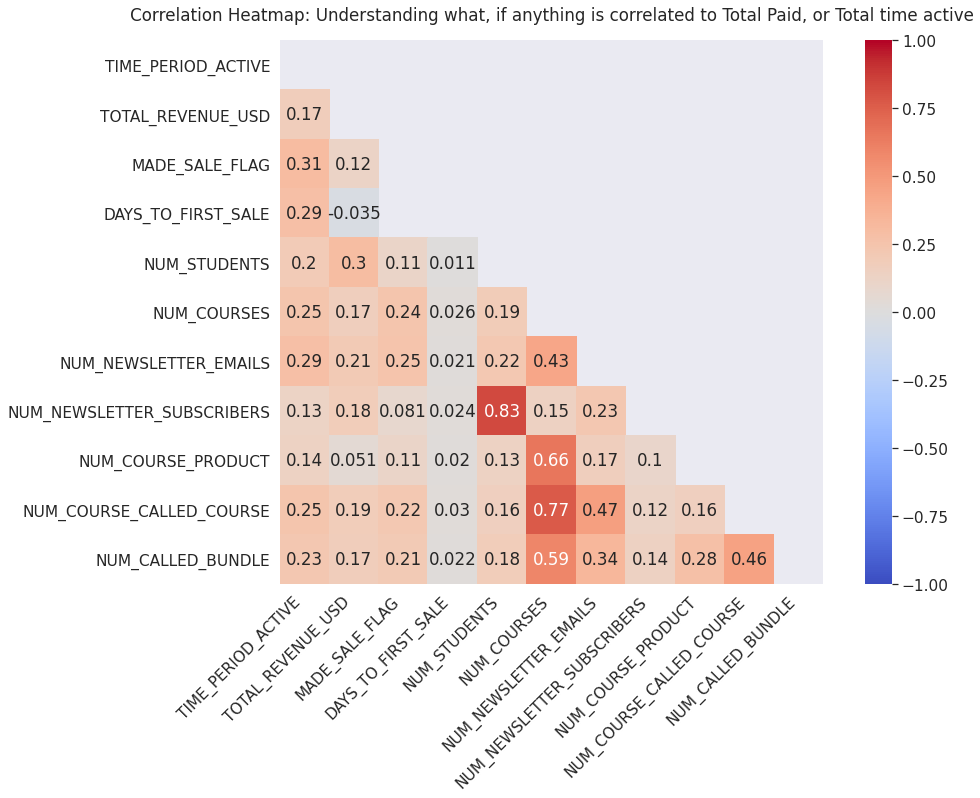

In [238]:
# Final correlation plot

set_1 = ['TIME_PERIOD_ACTIVE','TOTAL_REVENUE_USD','MADE_SALE_FLAG','DAYS_TO_FIRST_SALE','NUM_STUDENTS','NUM_COURSES',
 'NUM_NEWSLETTER_EMAILS','NUM_NEWSLETTER_SUBSCRIBERS','NUM_COURSE_PRODUCT','NUM_COURSE_CALLED_COURSE',
 'NUM_CALLED_BUNDLE']

sns.set(font_scale=1.4)
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

corr = data_final[set_1].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


ax.set_title("Correlation Heatmap: Understanding what, if anything is correlated to Total Paid, or Total time active", pad =20)

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    annot=True,
    mask = mask,
    fmt='.2g'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [239]:
data_final[set_1].describe()

,TIME_PERIOD_ACTIVE,TOTAL_REVENUE_USD,MADE_SALE_FLAG,DAYS_TO_FIRST_SALE,NUM_STUDENTS,NUM_COURSES,NUM_NEWSLETTER_EMAILS,NUM_NEWSLETTER_SUBSCRIBERS,NUM_COURSE_PRODUCT,NUM_COURSE_CALLED_COURSE,NUM_CALLED_BUNDLE
count,14779.000000,1.477900e+04,14779.000000,7602.000000,14779.000000,14779.00000,14779.000000,14779.000000,14779.000000,14779.000000,14779.000000
mean,7.740510,7.049199e+03,0.514379,63.125099,394.739022,11.91109,25.571148,160.287232,3.165167,6.738142,0.868191
std,7.934636,5.511743e+04,0.499810,109.453709,2597.653243,23.35662,54.263455,1527.883342,12.288662,13.721592,2.444502
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000e+00,0.000000,8.000000,2.000000,2.00000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,5.000000,2.060000e+00,1.000000,24.000000,18.000000,5.00000,10.000000,0.000000,1.000000,3.000000,0.000000
75%,10.000000,1.122710e+03,1.000000,69.000000,118.000000,13.00000,26.000000,18.000000,3.000000,7.000000,1.000000
max,56.000000,2.366071e+06,1.000000,1378.000000,165309.000000,629.00000,1798.000000,119196.000000,606.000000,479.000000,66.000000


This data run is better

1. The strong correlation between Total Paid and Time Period active remains
2. The most positively correlated variable with time period active is making a sale, more students, more newsletter emails, and creating courses of type course and bundle.
3. None of the attribution channels had a positive correlation on time spent on platform, implying where a user comes from is not important to LTV

In terms of "magic metric", it feels like making a sale, the num courses or newsletter emails are good variables to explore

The correlations are still not strong, and naturally, correlation doesn't imply causation. 

>50% of users leave the platform within 5 months. In order to study what explains high value users, we will restrict to users that are currently active that joined the platform at least 5 months ago (October 2020).




# What do these correlated relationships look like?

In [206]:
# Take only data from cohort earlier than October
# Our y variable now will be site_status_active

corr_variables = ['SITE_STATUS_active',
                  'YEAR_JOINED_post_2020',
                  'YEAR_JOINED_pre_2020',
                  'TIME_PERIOD_ACTIVE',
                  'TOTAL_REVENUE_USD',
                  'MADE_SALE_FLAG',
                  'DAYS_TO_FIRST_SALE',
                  'NUM_STUDENTS',
                  'NUM_COURSES',
                  'NUM_NEWSLETTER_EMAILS',
                  'NUM_NEWSLETTER_SUBSCRIBERS',
                  'NUM_COURSE_PRODUCT',
                  'NUM_COURSE_CALLED_COURSE',
                  'NUM_CALLED_BUNDLE',
                  'COHORT']

model = data_final[corr_variables]

# Restrict to users that joined max in October 2020

model = model.loc[data_final['COHORT']<='2020-10-01']

In [207]:
model['COHORT'].unique()
model.describe()
# We have 10k variables
# Fairly even split between active and inactive!

,SITE_STATUS_active,YEAR_JOINED_post_2020,YEAR_JOINED_pre_2020,TIME_PERIOD_ACTIVE,TOTAL_REVENUE_USD,MADE_SALE_FLAG,DAYS_TO_FIRST_SALE,NUM_STUDENTS,NUM_COURSES,NUM_NEWSLETTER_EMAILS,NUM_NEWSLETTER_SUBSCRIBERS,NUM_COURSE_PRODUCT,NUM_COURSE_CALLED_COURSE,NUM_CALLED_BUNDLE
count,10907.000000,10907.000000,10907.000000,10907.000000,1.090700e+04,10907.000000,6054.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000
mean,0.427157,0.572476,0.427524,9.794352,9.056477e+03,0.555056,69.996201,497.629504,13.574035,29.411571,201.586779,3.715595,7.629504,1.036307
std,0.494688,0.494742,0.494742,8.277285,6.335685e+04,0.496982,117.267793,3005.390188,25.760138,59.568347,1769.015628,14.051743,15.068569,2.721528
min,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.000000,0.000000e+00,0.000000,9.000000,3.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000,8.000000,3.900000e+01,1.000000,27.000000,26.000000,6.000000,11.000000,0.000000,1.000000,3.000000,0.000000
75%,1.000000,1.000000,1.000000,12.000000,1.829550e+03,1.000000,78.000000,167.000000,15.000000,31.000000,28.000000,3.000000,8.000000,1.000000
max,1.000000,1.000000,1.000000,56.000000,2.366071e+06,1.000000,1378.000000,165309.000000,629.000000,1798.000000,119196.000000,606.000000,479.000000,66.000000


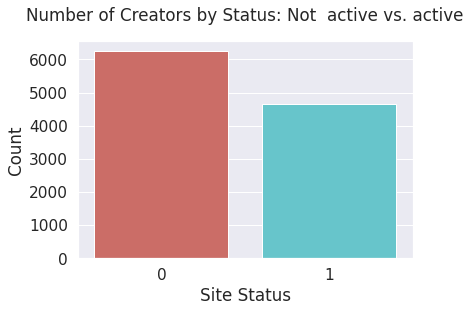

In [208]:
# Lets look at some correlations here, e.g. how does the days to first sale correlate to active? I.e. share that are active by days to sale
#My outcome variable is site status active
# Look at days to first sale

model['SITE_STATUS_active'].value_counts

sns.countplot(x='SITE_STATUS_active',data=model,palette='hls')

plt.title("Number of Creators by Status: Not  active vs. active", pad=20)

plt.xlabel('Site Status')
plt.ylabel('Count')

plt.show()

Text(0.5, 1.0, 'Number of Currently Active Users by days of purchase')

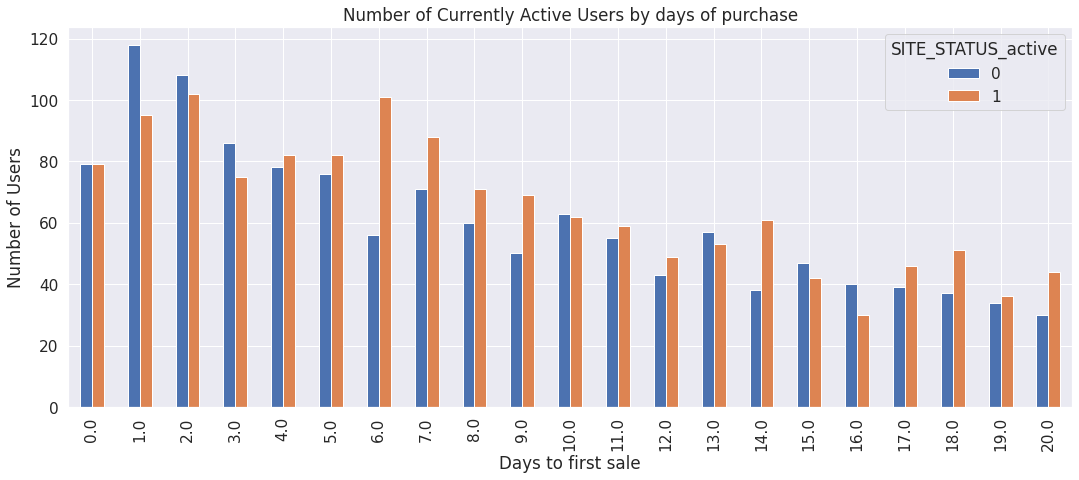

In [209]:
#plot = model.groupby('DAYS_TO_FIRST_SALE')['SITE_STATUS_active'].nunique().reset_index(name='t')

#Limit size
df=model.loc[model['DAYS_TO_FIRST_SALE']<=20]

table=pd.crosstab(df['DAYS_TO_FIRST_SALE'],df['SITE_STATUS_active'])
table.plot(kind='bar',figsize=(18,7),xlabel='Days to first sale', ylabel='Number of Users')

plt.title('Number of Currently Active Users by days of purchase')

In [210]:
table.head(10)

SITE_STATUS_active,0,1
DAYS_TO_FIRST_SALE,,
0.0,79,79
1.0,118,95
2.0,108,102
3.0,86,75
4.0,78,82
5.0,76,82
6.0,56,101
7.0,71,88
8.0,60,71


- Making a sale on the 6th and 14th daay joininh coincides with a high numnber of active users 5 days after

Text(0.5, 1.0, 'Number of Currently Active Users by days of purchase')

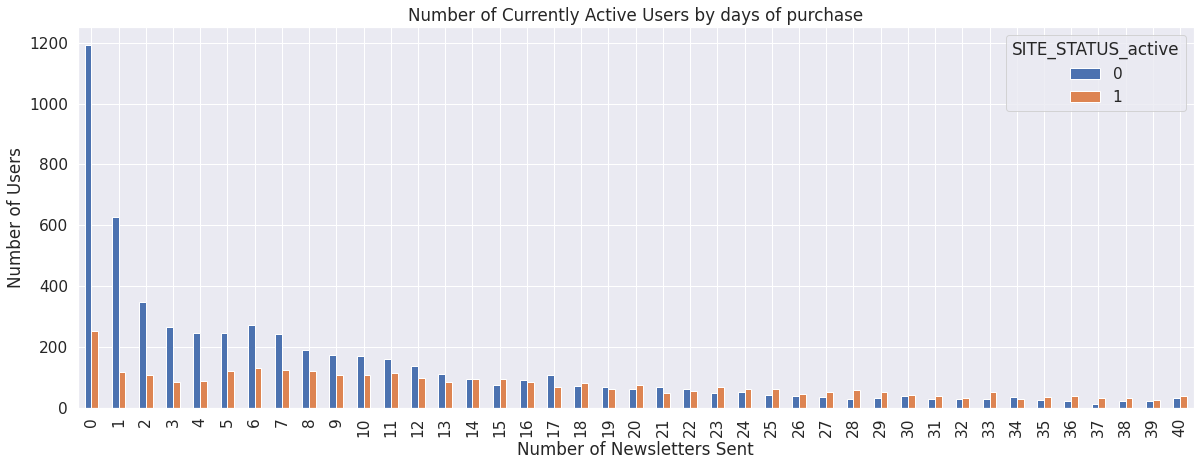

In [211]:
#Limit size
df=model.loc[model['NUM_NEWSLETTER_EMAILS']<=40]

table=pd.crosstab(df['NUM_NEWSLETTER_EMAILS'],df['SITE_STATUS_active'])
table.plot(kind='bar',figsize=(20,7),xlabel='Number of Newsletters Sent', ylabel='Number of Users')

plt.title('Number of Currently Active Users by days of purchase')

In [212]:

# Calculte percentage churned vs active over 15 newsletters

d15 = model.loc[model['NUM_NEWSLETTER_EMAILS']>15]

count_active_over15 = len(d15[d15['SITE_STATUS_active']==1])
count_churn_over15 = len(d15[d15['SITE_STATUS_active']==0])

pct_churn= count_churn_over15/(count_churn_over15+count_active_over15)
print("percentage of churn is", pct_churn*100)
pct_active = count_active_over15/(count_churn_over15+count_active_over15)
print("percentage of active", pct_active*100)

percentage of churn is 37.563676633444075
percentage of active 62.436323366555925


- If you send over 15 newsletters you are likely to stay active, compred to if you send fewer
- In fact, 62% of users that send over 15 newsletter emails are active 5 months after joining

In [213]:
table.head(15)

SITE_STATUS_active,0,1
NUM_NEWSLETTER_EMAILS,,
0,1192,251
1,627,116
2,347,108
3,266,85
4,246,89
5,246,119
6,272,129
7,243,124
8,189,120


# Model Part 2

In [214]:
# Based on Cross tabs above,make final data changes

# Create a flag for over 15 newsletters
model['over_15'] = [1 if num_emails >=15 else 0 for num_emails in model['NUM_NEWSLETTER_EMAILS']]
# Create a flag for 6th and 14th day sales
model['day_6_sales'] = [1 if days ==6 or days==14 else 0 for days in model['NUM_NEWSLETTER_EMAILS']]

# Cap first_day_to_sales at 100
model['DAYS_TO_FIRST_SALE'] = [100 if days >=100 else days for days in model['DAYS_TO_FIRST_SALE']]
# Cap no. newsletters at 50
model['NUM_NEWSLETTER_EMAILS'] = [50 if num_emails >=50 else num_emails for num_emails in model['NUM_NEWSLETTER_EMAILS']]


In [215]:
# What's the max number of days before something is sold
model['DAYS_TO_FIRST_SALE'] = model['DAYS_TO_FIRST_SALE'].replace(np.nan, -1)

In [241]:
# Check columns types
#model.dtypes
model = model.drop(columns=['COHORT'])
#np.asarray(model)

# split X and y into training and testing sets
X = model.loc[:, model.columns != 'SITE_STATUS_active']
y = model.loc[:, model.columns == 'SITE_STATUS_active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [217]:
model.describe()

,SITE_STATUS_active,YEAR_JOINED_post_2020,YEAR_JOINED_pre_2020,TIME_PERIOD_ACTIVE,TOTAL_REVENUE_USD,MADE_SALE_FLAG,DAYS_TO_FIRST_SALE,NUM_STUDENTS,NUM_COURSES,NUM_NEWSLETTER_EMAILS,NUM_NEWSLETTER_SUBSCRIBERS,NUM_COURSE_PRODUCT,NUM_COURSE_CALLED_COURSE,NUM_CALLED_BUNDLE,over_15,day_6_sales
count,10907.000000,10907.000000,10907.000000,10907.000000,1.090700e+04,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000,10907.000000
mean,0.427157,0.572476,0.427524,9.794352,9.056477e+03,0.555056,22.500229,497.629504,13.574035,18.118364,201.586779,3.715595,7.629504,1.036307,0.429541,0.054002
std,0.494688,0.494742,0.494742,8.277285,6.335685e+04,0.496982,34.796862,3005.390188,25.760138,18.007635,1769.015628,14.051743,15.068569,2.721528,0.495033,0.226032
min,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.000000,0.000000e+00,0.000000,-1.000000,3.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,8.000000,3.900000e+01,1.000000,3.000000,26.000000,6.000000,11.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,12.000000,1.829550e+03,1.000000,32.000000,167.000000,15.000000,31.000000,28.000000,3.000000,8.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,56.000000,2.366071e+06,1.000000,100.000000,165309.000000,629.000000,50.000000,119196.000000,606.000000,479.000000,66.000000,1.000000,1.000000


In [242]:
# Individual Coefficients across all categories
logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary2())

# Narrows it down to:
# 'day_6_sales',
# 'NUM_NEWSLETTER_EMAILS',
# 'YEAR_JOINED_post_2020' ,     
# 'YEAR_JOINED_pre_2020',       
# 'TIME_PERIOD_ACTIVE',         
# 'TOTAL_REVENUE_USD',           
# 'MADE_SALE_FLAG',             
# 'DAYS_TO_FIRST_SALE'                     

set_final = ['day_6_sales',
 'NUM_NEWSLETTER_EMAILS',
 'YEAR_JOINED_post_2020' ,     
 'YEAR_JOINED_pre_2020',       
 'TIME_PERIOD_ACTIVE',         
 'TOTAL_REVENUE_USD',           
 'MADE_SALE_FLAG',             
 'DAYS_TO_FIRST_SALE',
 'SITE_STATUS_active']

model = model[set_final]

Optimization terminated successfully.
         Current function value: 0.461679
         Iterations 7
                              Results: Logit
Model:                  Logit                Pseudo R-squared:   0.324     
Dependent Variable:     SITE_STATUS_active   AIC:                10101.0644
Date:                   2021-03-31 05:42     BIC:                10210.5218
No. Observations:       10907                Log-Likelihood:     -5035.5   
Df Model:               14                   LL-Null:            -7444.0   
Df Residuals:           10892                LLR p-value:        0.0000    
Converged:              1.0000               Scale:              1.0000    
No. Iterations:         7.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
YEAR_JOINED_post_

In [243]:
X = model.loc[:, model.columns != 'SITE_STATUS_active']
y = model.loc[:, model.columns == 'SITE_STATUS_active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)



In [244]:
from sklearn import preprocessing


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [245]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 22,random_state = 40)
rf.fit(X_train,y_train.values.ravel())
y_pred=rf.predict(X_test)

print('Random Forest Score : ',rf.score(X_test,y_test))

Random Forest Score :  0.7942794279427943


In [246]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1218,  338],
       [ 223,  948]])

Text(0.5, 637.6, 'Predicted label')

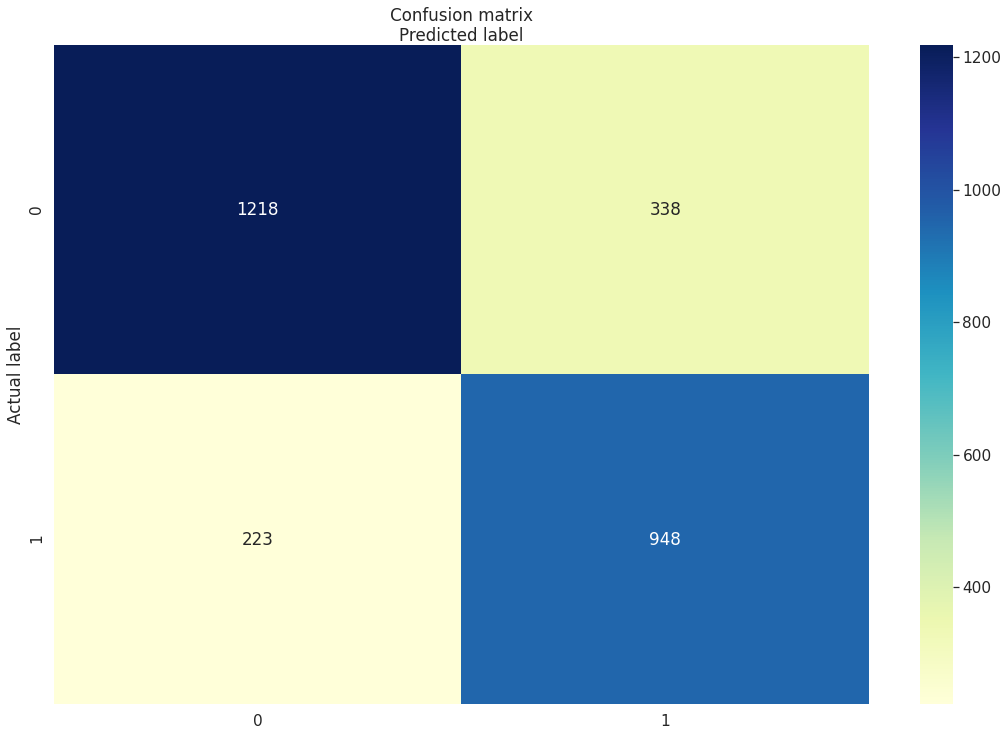

In [247]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=a4_dims)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Recommendations
- With the available data, our model can predict if an individual who joined podia over 5 months ago will be active with 80% accuracy. The longer an individual has been on the platform, the more likely they are to stay, in addition to making a sale, making a sale on day 6 and sending more email newsletters increases the likelihood of being active 5 months in.

Based on these results we recommend:

# 1. Business Model
- Whilst there is a correlation between creator revenue and time period active, the regression coefficient is 0 implying more creator revenue gives you a 50/50 chance of being active, so basically chance! If a user is not staying on the platform when they make money, it feels like the platform may not be providing them with value. 

**Possible Solutions:**
1.   Change business model to take a % comission of course creators revenue, this would directly align the incentives of Podia with those of the creators.
2.   Conduct in-depth reserch with creators that made a profit using the platfrom but left anyway to understand driving factors behind leaving platform.



# 2. Magic Metric
- Sending more email newsletters increases the likelihood that a customer stays active!
- Getting a sale on day 6 increases the likelihgood of being active by about 6%

**Possible Solutions:**
- Incentivizing creators to make newsletters by sending them emails, similar to the "Thinking of Upgrading emails you already send"
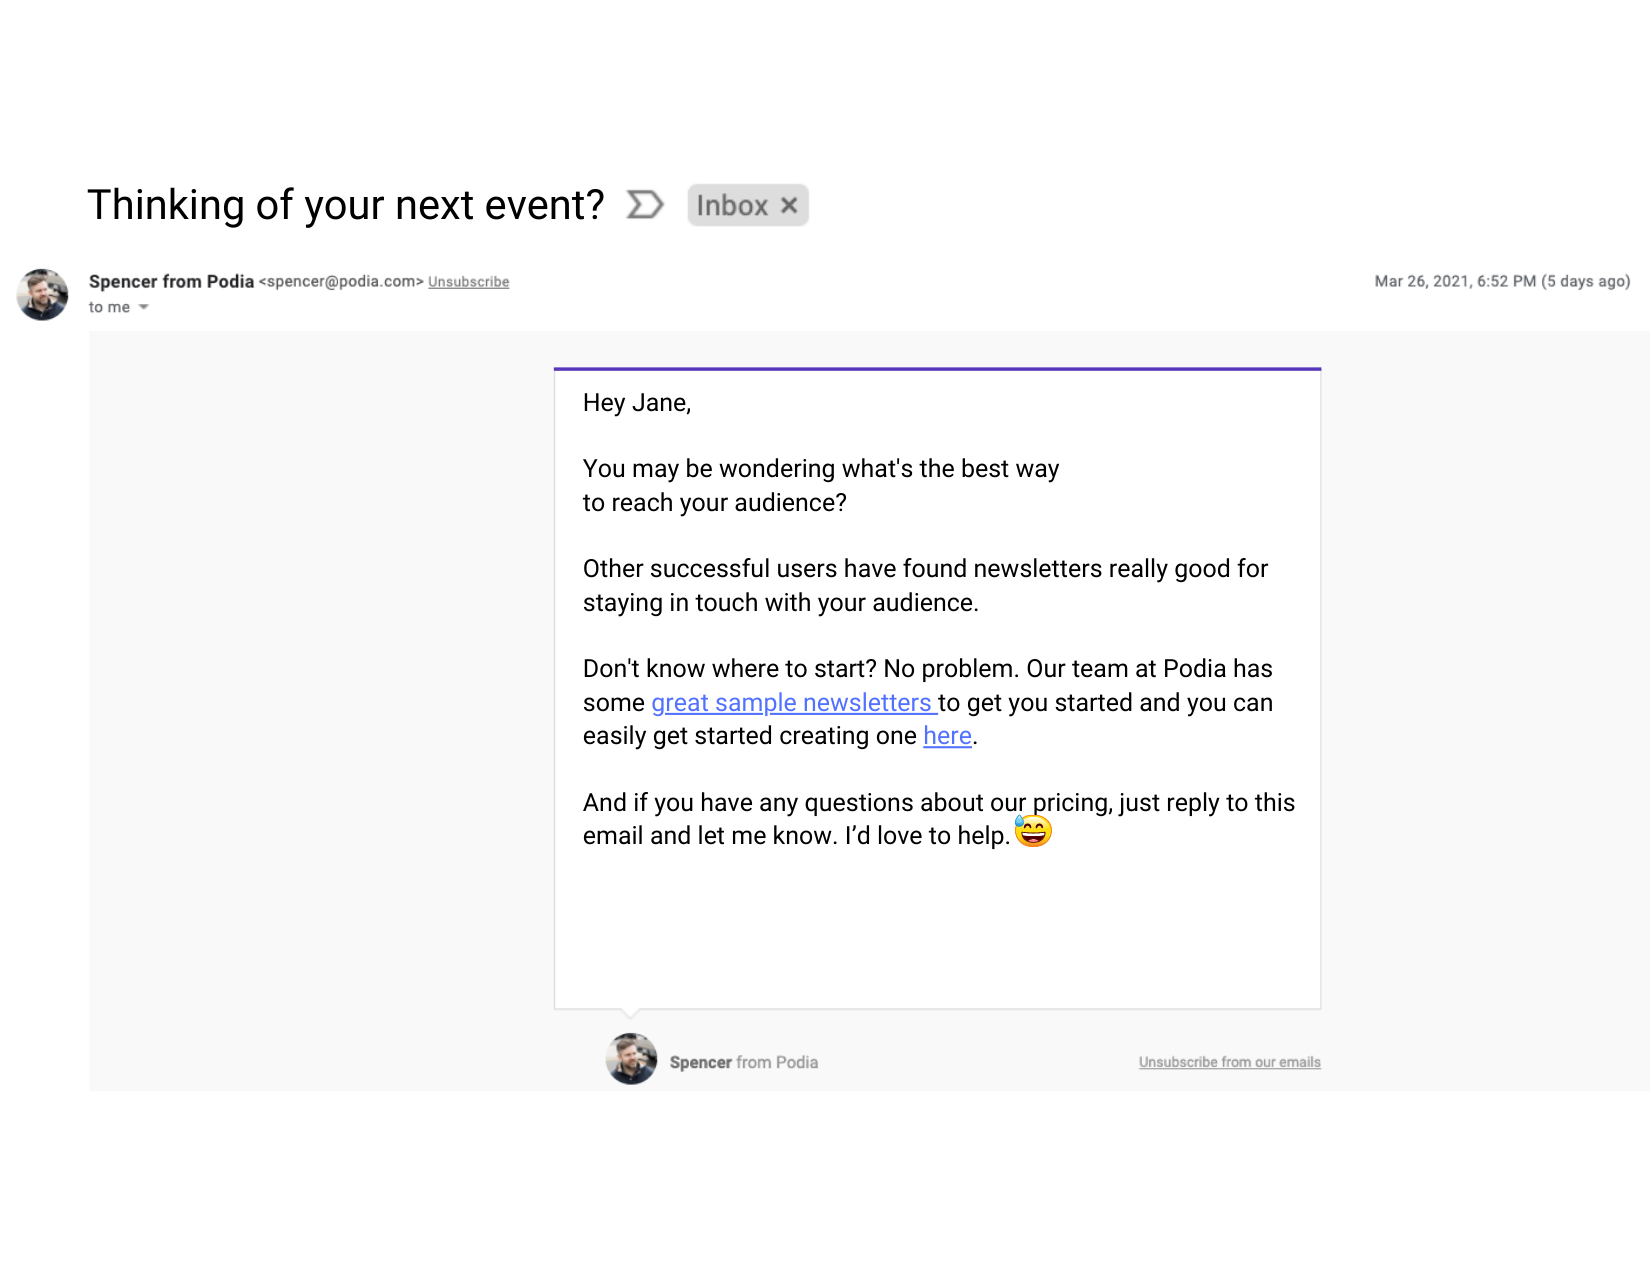 
- Could send monthly 'Why don't you write newsletter reminders'?
- Once a creator has signed up to the platform, create a checklist that allows them to launch an event by day 6, complete with daily reminders on their progress.

# 3. Course Categories
- Currently, there are **254,137** course categories in the database, with that breadth its impossible to understand the relationship between course type and retention. 

**Possible Solutions:**
1.   Conduct clustering analysis on existing categories to find a reduced set,of perhaps 20 of course categories, re-run analysis above and see if a) Course type predicts retention and then b) use that knowledge to acquire/retain creators of a certain category. (DC could do this)
2.   Create manual classification for courses internally. Create limited set of e.g. 20 course categories. Make course tagging a required choice(e.g. in the form of a drop-down) in course setup. 

## APPENDIX

In [ ]:
# Check that all indexes start as 0
agg.loc[agg['COHORT'] =='2016-09-01']
